In [1]:
import os
from tqdm import tqdm
import cv2
import multiprocessing
from metadata import Metadata
import matplotlib.pyplot as plt
from dredFISH.Processing.Section import *
import numpy as np
import torch
from scipy.ndimage import gaussian_filter,percentile_filter,median_filter,minimum_filter
dataset_path = '/orangedata/Images2024/Zach/MouseBrainAtlas/WTM02_3.1.A_2.3.B_3.3.D_1.2.E_2024Apr01'
image_metadata = Metadata(dataset_path)


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
sorted([i for i in image_metadata.acqnames if 'ybe21' in i])

['Hybe21_69', 'Hybe21_70', 'Hybe21_71', 'Hybe21_72']

In [3]:
sorted([i for i in image_metadata.acqnames if 'rip21' in i])

['Strip21_65', 'Strip21_66', 'Strip21_67', 'Strip21_68']

{'pixel_size': 0.49, 'bin': 2, 'process_pixel_size': 0.245, 'stitch_raw': False, 'stitch_rotate': 0, 'stitch_flipud': False, 'stitch_fliplr': True, 'register_stitch_reference': True, 'segment_gpu': False, 'fishdata': 'fishdata_2024Apr012e', 'QC_pixel_size': 2, 'diameter': 8, 'segment_diameter': 32.6530612244898, 'nucstain_channel': 'DeepBlue', 'nucstain_acq': 'hybe21', 'total_channel': 'FarRed', 'total_acq': 'all', 'outpath': '/greendata/GeneralStorage/Data/dredFISH/', 'nuclei_size_threshold': 65.3061224489796, 'ratio': 0.1225, 'n_pixels': [4896, 4096], 'border': 1000, 'highpass_function': 'spline_robust_min', 'highpass_sigma': 50, 'highpass_smooth_function': 'median', 'highpass_smooth': 3, 'strip': True, 'model_types': ['total'], 'dapi_thresh': 1000, 'background_estimate_iters': 0, 'stain_correction': False, 'stain_correction_downsample': 10, 'stain_correction_kernel': 1000, 'overlap': 0.02, 'segment_min_size': 326.53061224489795, 'overwrite_report': True, 'overwrite_louvain': True, '

2024 April 12 21:51:33 Generating FlatField Hybe21_70 FarRed: 100%|██████████| 283/283 [03:26<00:00,  1.37it/s]


<Figure size 640x480 with 0 Axes>

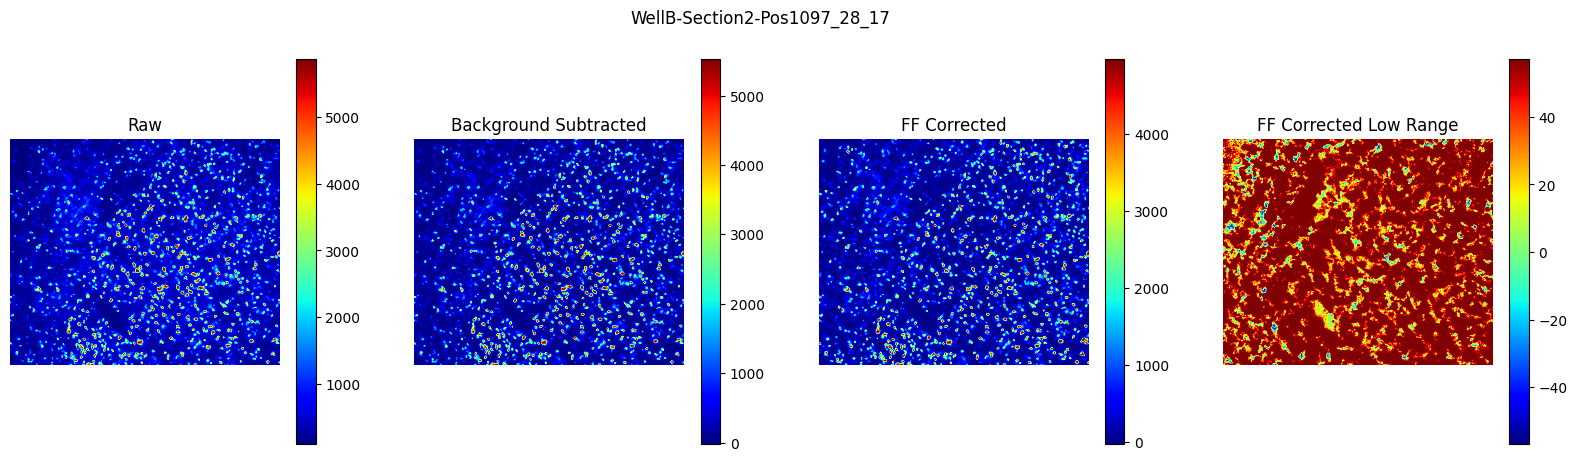

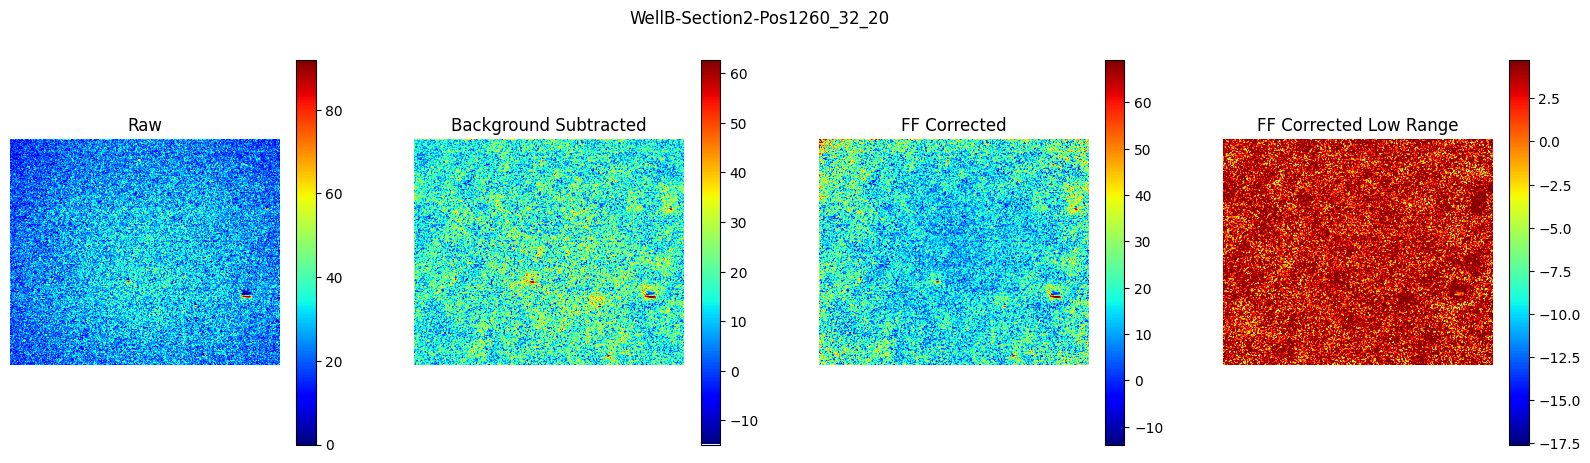

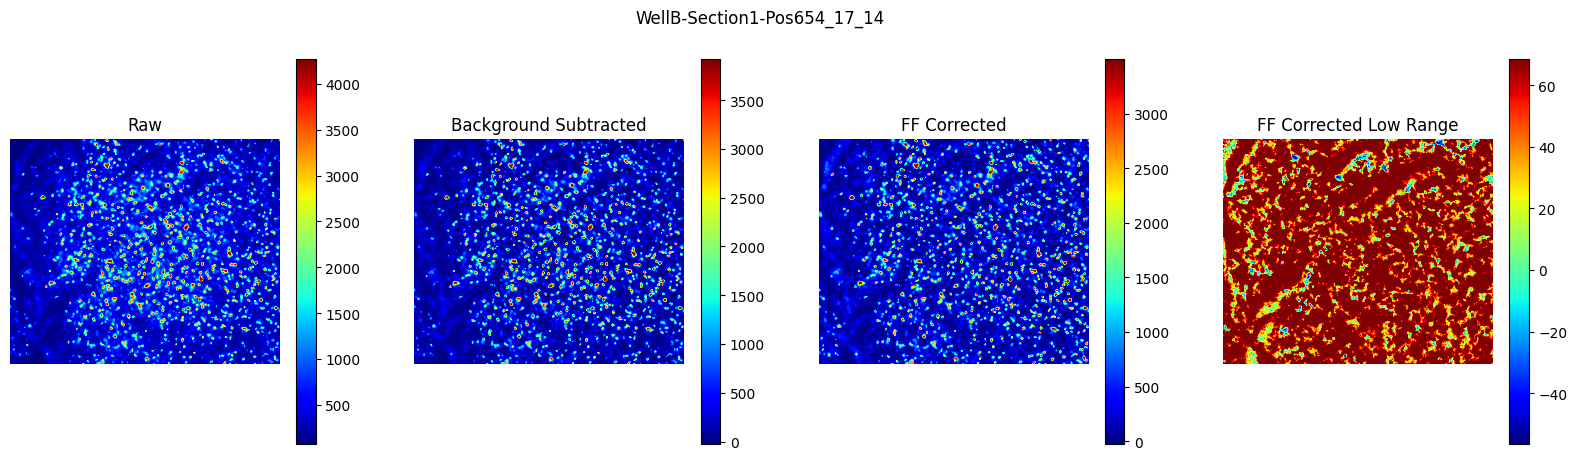

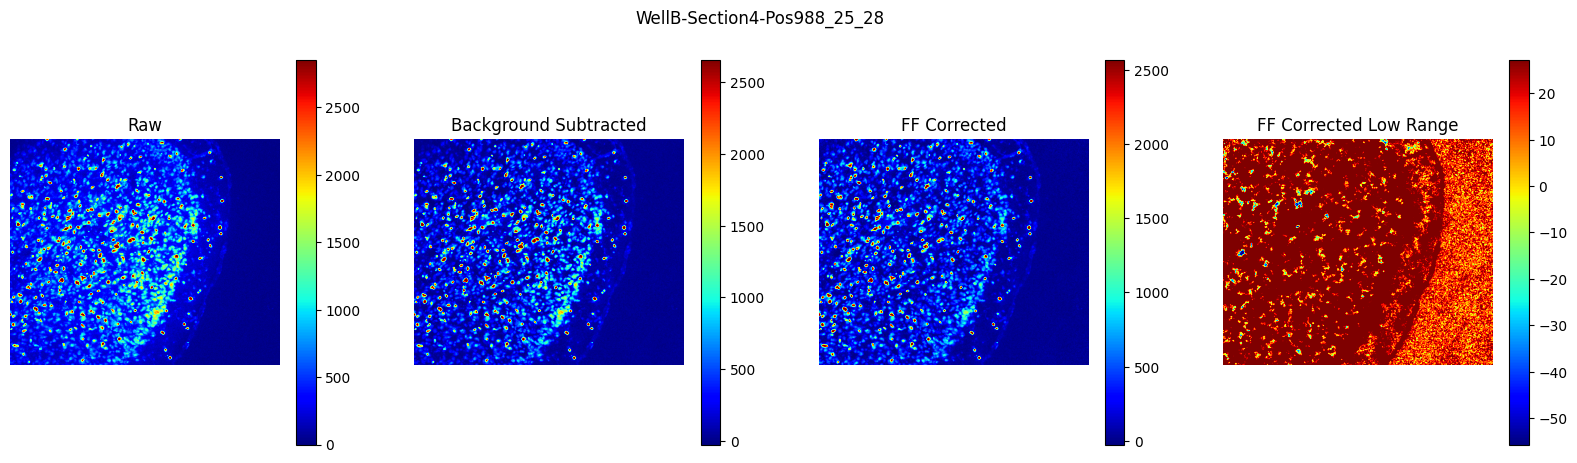

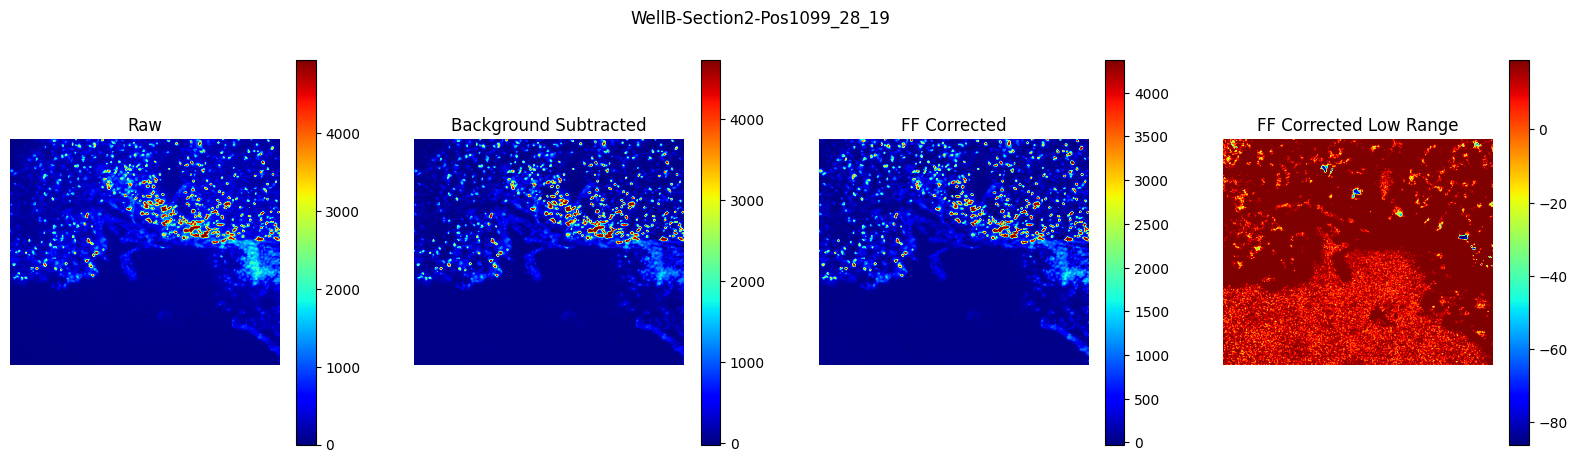

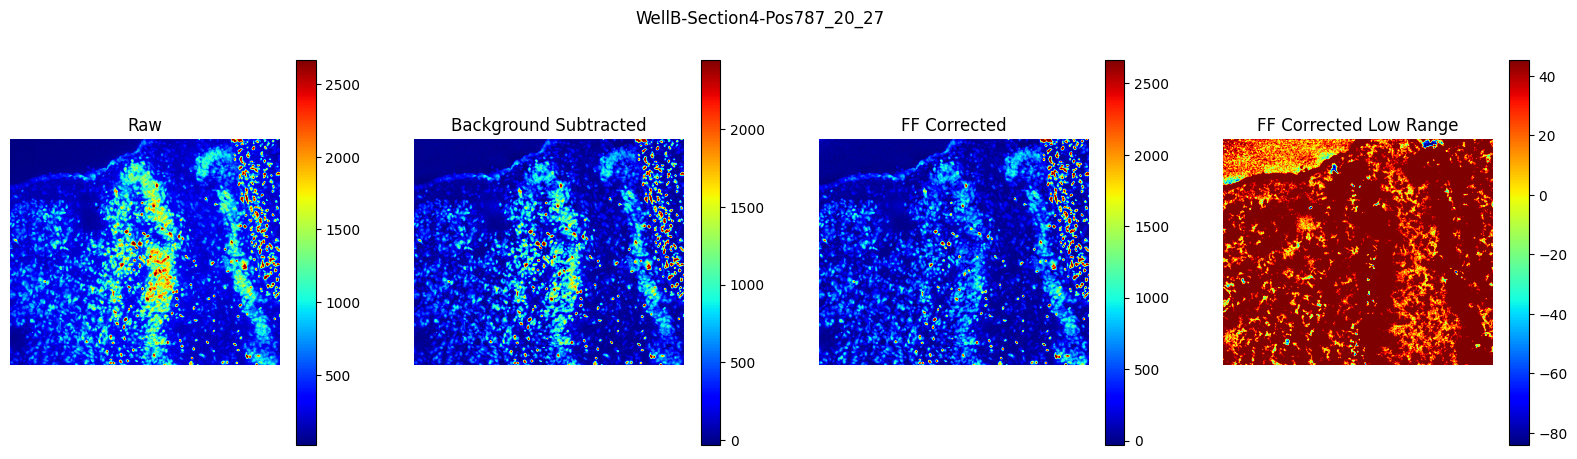

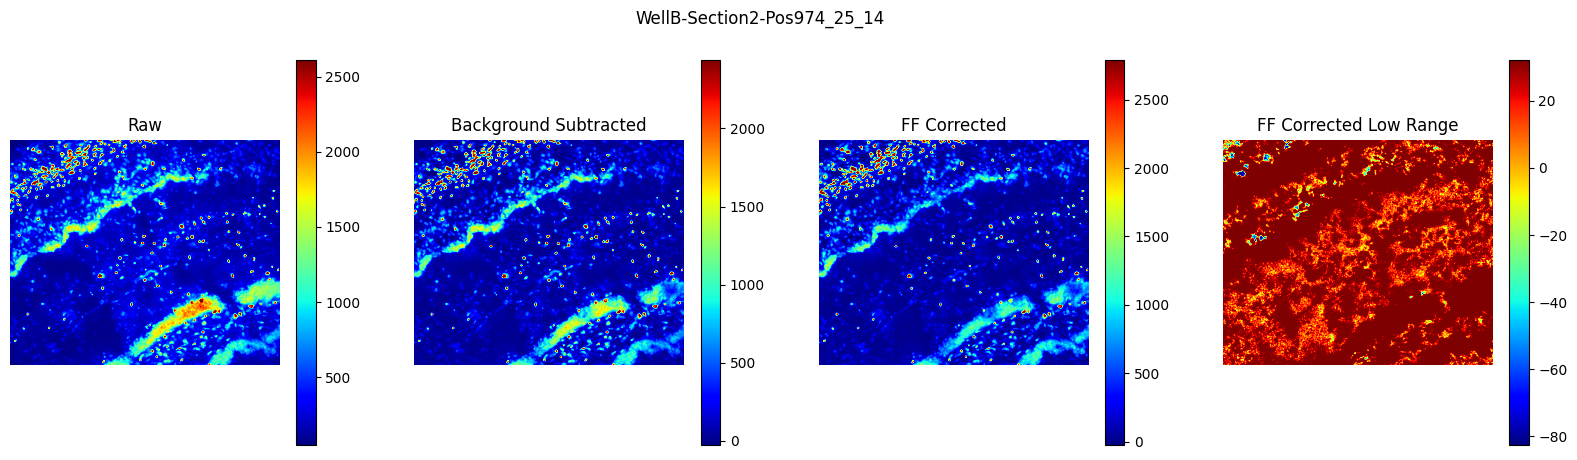

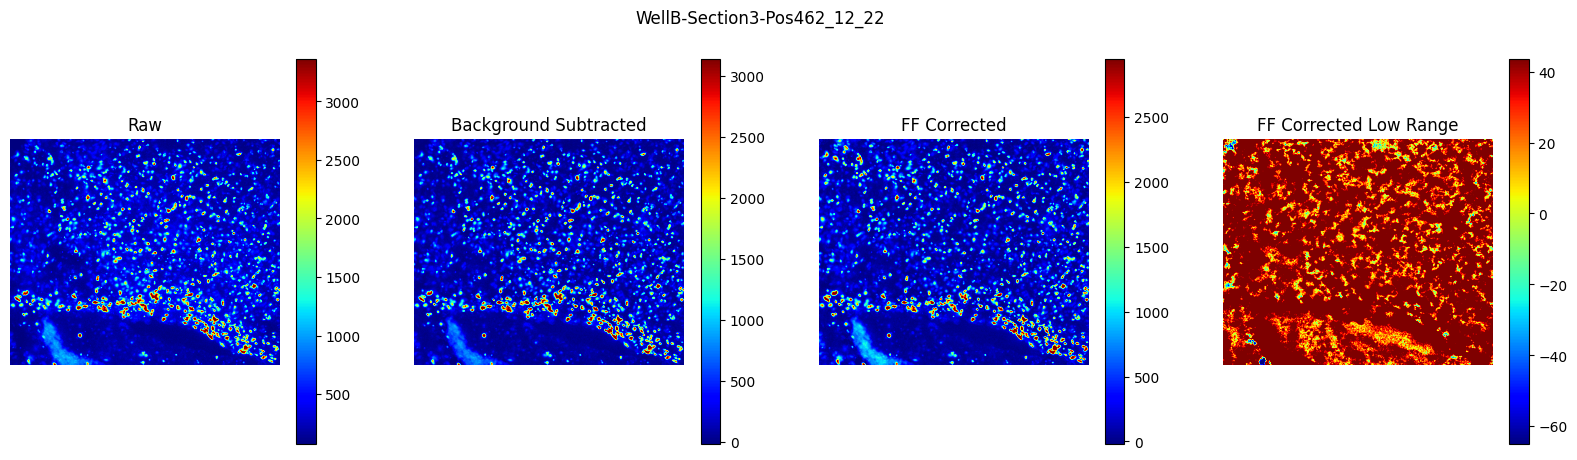

In [4]:
config = importlib.import_module('dredfish_processing_config_tree')
parameters = config.parameters
# parameters['acq_FF'] = False
# parameters['acq_constant'] = False

# parameters['use_FF'] = True
# parameters['use_constant'] = False

# parameters['fit_FF'] = False
# parameters['fit_constant'] = False

# parameters['smooth_FF'] = False
# parameters['smooth_constant'] = False

# parameters['clip_FF'] = False
# parameters['clip_constant'] = False

# parameters['FF_poly_degrees'] = 5
# parameters['constant_poly_degrees'] = 5

# parameters['post_strip_FF'] = True
# parameters['process_img_before_FF'] = True

# parameters['debug'] = False
# parameters['FF_n_cpu'] = 1
parameters['numpy_dtype'] = np.float32
parameters['pytorch_dtype'] = torch.float32

acq = 'Hybe21_70'
bkg_acq = 'Strip21_66'
channel = 'FarRed'
print(parameters)

FF,constant = generate_FF_parallel(image_metadata,acq=acq,channel=channel,bkg_acq=bkg_acq,parameters=parameters,verbose=True)

FF = np.clip(FF,10e-5,10e5)
constant = np.clip(constant,0,10e5)
fig,axs = plt.subplots(1,4,figsize=[20,5])
axs = axs.ravel()
img = FF.numpy()
vmin,vmax = np.percentile(img.ravel(),[1,99])
im = axs[0].imshow(np.clip(img,vmin,vmax),cmap='jet')
axs[0].set_title('FF')
plt.colorbar(im,ax=axs[0])

img = median_filter(FF.numpy(),10)
vmin,vmax = np.percentile(img.ravel(),[1,99])
im=axs[1].imshow(np.clip(img,vmin,vmax),cmap='jet')
plt.colorbar(im,ax=axs[1])
axs[1].set_title('FF median')
plt.show()

img = constant.numpy()
vmin,vmax = np.percentile(img.ravel(),[1,99])
im = axs[2].imshow(np.clip(img,vmin,vmax),cmap='jet')
axs[2].set_title('constant')
plt.colorbar(im,ax=axs[2])

img = median_filter(constant.numpy(),10)
vmin,vmax = np.percentile(img.ravel(),[1,99])
im=axs[3].imshow(np.clip(img,vmin,vmax),cmap='jet')
plt.colorbar(im,ax=axs[3])
axs[3].set_title('constant median')
plt.show()

posnames = image_metadata.image_table[image_metadata.image_table.acq==acq].Position.unique()
for posname in np.random.choice(posnames,10):
    img = image_metadata.stkread(Position=posname,Channel=channel,acq=acq).min(2).astype(np.float32)
    img = block_reduce(image_filter(img,'median',2), tuple([parameters['bin'],parameters['bin']]), np.mean)
    if channel=='FarRed':
        bkg = image_metadata.stkread(Position=posname,Channel=channel,acq=bkg_acq).min(2).astype(np.float32)
        bkg = block_reduce(image_filter(bkg,'median',2), tuple([parameters['bin'],parameters['bin']]), np.mean)
        img = img-bkg
    # img = np.array(Image.fromarray(image_filter(img,'median',2)).resize(parameters['n_pixels'],Image.BICUBIC),dtype=parameters['numpy_dtype'])
    signal = median_filter(img,2)
    signal = np.clip(signal,0,None)

    fig,axs = plt.subplots(1,4,figsize=[20,5])
    axs = axs.ravel()
    fig.suptitle(posname)
    img = signal.copy()
    vmin,vmax = np.percentile(img.ravel(),[1,99])
    ax = axs[0]
    im = ax.imshow(np.clip(img,vmin,vmax),cmap='jet')
    ax.set_title('Raw')
    ax.axis('off')
    plt.colorbar(im,ax=ax)

    img = process_img(signal.copy(),parameters=parameters,FF=1,constant=0)
    vmin,vmax = np.percentile(img.ravel(),[1,99])
    ax = axs[1]
    im = ax.imshow(np.clip(img,vmin,vmax),cmap='jet')
    ax.set_title('Background Subtracted')
    ax.axis('off')
    plt.colorbar(im,ax=ax)

    img = process_img(signal.copy(),parameters=parameters,FF=FF.numpy(),constant=constant.numpy())
    vmin,vmax = np.percentile(img.ravel(),[1,99])
    ax = axs[2]
    im = ax.imshow(np.clip(img,vmin,vmax),cmap='jet')
    ax.set_title('FF Corrected')
    ax.axis('off')
    plt.colorbar(im,ax=ax)

    vmin,vmax = np.percentile(img.ravel(),[0.1,25])
    ax = axs[3]
    im = ax.imshow(np.clip(img,vmin,vmax),cmap='jet')
    ax.set_title('FF Corrected Low Range')
    ax.axis('off')
    plt.colorbar(im,ax=ax)

    plt.show()


In [5]:
img.shape

(1024, 1224)